In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import dgl
from dgl.nn.pytorch import GraphConv, SAGEConv
from dgl.data.utils import save_graphs, load_graphs
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [46]:
def graph_eigens(graph):
    '''
    The input is the graph, and the output is a normalized spectrum of the graph using the functions on 'Networkx'.
    '''
    return nx.normalized_laplacian_spectrum(graph)

def graph_spec_generator(N_lower, N_upper, num_iter):
    '''
    The input here is the uniform sampling bound introduced above, and the number of sampling iterations. For each iteration, we choose
    an m and an n, the size and order, then we generate a random graph. Then we use the 'graph_eigens' to compute the spectra for this graph, and we 
    store the data in graph_spec_detail in the form '[w,z]' as mentioned above.
    '''
    graphs = []
    eigens = []
    for index in range(1,num_iter):
        n = np.random.randint(N_lower, N_upper)
        Mbound = n *(n-1) // 2 # complete graph
        m = np.random.randint(1,Mbound)
        g=nx.gnm_random_graph(n, m)
        graphs.append(g)
        eigens.append(max(graph_eigens(g))) # made it return only the largest eigen value

    return graphs, eigens

In [93]:
train_nx_graphs, train_eigens = graph_spec_generator(40, 50, 10000)
test_nx_graphs, test_eigens = graph_spec_generator(40, 50, 3000)

In [94]:
def save_to_file(g_fname, nx_g_list, eigens_list):
    eigens = torch.tensor(eigens_list, dtype=torch.float64) # convert eigens list into tensor
    dgl_g_list = list(map(dgl.DGLGraph, nx_g_list)) # convert to DGL graphs
    save_graphs(g_fname, dgl_g_list, {'eigens': eigens}) # store the eigen values in the 'labels' dict.

In [95]:
save_to_file("train_graphs", train_nx_graphs, train_eigens)
save_to_file("test_graphs", test_nx_graphs, test_eigens)

In [96]:
def load_from_file(g_fname):
    graphs, labels = load_graphs(g_fname)
    eigens = labels['eigens']
    return graphs, eigens

In [97]:
train_graphs, train_eigens = load_from_file("train_graphs")
test_graphs, test_eigens = load_from_file("test_graphs")

In [105]:
print("Length of training list:", len(train_graphs))
print("Length of test list:", len(test_graphs))

Length of training list: 9999
Length of test list: 2999


In [112]:
class EigenDataset(Dataset):
    def __init__(self, g_fname):
        super().__init__()
        self.graphs, self.eigens = load_from_file(g_fname)
        
    def __len__(self):
        
        return len(self.eigens)
    
    def __getitem__(self, idx):
        
        g = self.graphs[idx]
        e = self.eigens[idx]
        
        return g, e

In [113]:
train_dataset = EigenDataset("train_graphs")
test_dataset = EigenDataset("test_graphs")

print("Length of training dataset:", len(train_dataset))
print("Length of test dataset:", len(test_dataset))

Length of training dataset: 9999
Length of test dataset: 2999


In [115]:
def get_train_and_test_dataloader(train_fname, test_fname):
    
    train_dataset = EigenDataset(train_fname)
    test_dataset = EigenDataset(test_fname)
    
    def collate(samples):
        graphs, labels = map(list, zip(*samples))
        batched_graph = dgl.batch(graphs)
        return batched_graph, torch.tensor(labels)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, collate_fn=collate)
    
    
    return train_dataloader, test_dataloader

In [116]:
train_dataloader, test_dataloader = get_train_and_test_dataloader(train_dataset, test_dataset)

In [117]:
def train(model, loss_func, optimizer, num_epochs, data_loader):
    
    model.train()
    
    epoch_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (bg, label) in enumerate(data_loader):
            prediction = model(bg)
            loss = loss_func(prediction.view(-1), label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach().item()
        epoch_loss /= (i + 1)
        print('Epoch {}, loss {:.6f}'.format(epoch, epoch_loss))
        epoch_losses.append(epoch_loss)
        
    return model, epoch_losses

In [118]:
def plot_loss_graph(losses):
    plt.title('Epoch loss averaged over minibatches')
    plt.plot(losses)
    plt.show()

In [121]:
def evaluate_model(model, test_dataloader):
    train_loss = 0
    for i, (bg, label) in enumerate(test_dataloader):
        prediction = model(bg)
        loss = loss_func(prediction.view(-1), label)
        train_loss += loss.detach().item()
    train_loss /= (i + 1)
    print("Loss:", train_loss)

In [119]:
class SAGEConv_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes, agr):
        super(SAGEConv_Classifier, self).__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim, agr)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim, agr)
        self.classify = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, g):
        h = g.in_degrees().view(-1, 1).float() # # initial node feature will be the the indegree
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

Data loaded!
Length of training dataset: 1

Starting Training
Epoch 0, loss 0.027660
Epoch 1, loss 0.000753
Epoch 2, loss 0.002715
Epoch 3, loss 0.001709
Epoch 4, loss 0.001859
Epoch 5, loss 0.001165
Epoch 6, loss 0.002892
Epoch 7, loss 0.003231
Epoch 8, loss 0.001971
Epoch 9, loss 0.001242


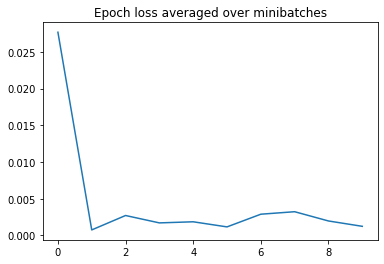

In [120]:
sage_model = SAGEConv_Classifier(1, 256, 1, 'gcn')
loss_func = nn.MSELoss()
optimizer = optim.Adam(sage_model.parameters(), lr=0.001)
train_dataloader, test_dataloader = get_train_and_test_dataloader("train_graphs", "test_graphs")

print("Data loaded!")
print("Length of training dataset:", len(list(train_dataloader)))
print()
print("Starting Training")

sage_model, losses = train(sage_model, loss_func, optimizer, 10, train_dataloader)

plot_loss_graph(losses)

In [129]:
test_mean = np.mean(np.array(test_eigens))
test_var = np.var(np.array(test_eigens))

print("Test mean:", test_mean)
print("Test var:", test_var)


MSE = 0 
for i in range(len(test_graphs)):
    g = test_graphs[i]
    SE = (test_eigens[i] - sage_model(g).item()) ** 2
    MSE += SE
MSE = MSE / len(test_graphs)
print(MSE)

Test mean: 1.3798833642917572
Test var: 0.06196262675137638
tensor(0.0011, dtype=torch.float64)


(array([108., 231., 284., 302., 289., 259., 197., 205., 164., 138.,  95.,
        114.,  88.,  80.,  45.,  48.,  55.,  45.,  32.,  32.,  37., 151.]),
 array([1.04166667, 1.08522727, 1.12878788, 1.17234848, 1.21590909,
        1.2594697 , 1.3030303 , 1.34659091, 1.39015152, 1.43371212,
        1.47727273, 1.52083333, 1.56439394, 1.60795455, 1.65151515,
        1.69507576, 1.73863636, 1.78219697, 1.82575758, 1.86931818,
        1.91287879, 1.95643939, 2.        ]),
 <a list of 22 Patch objects>)

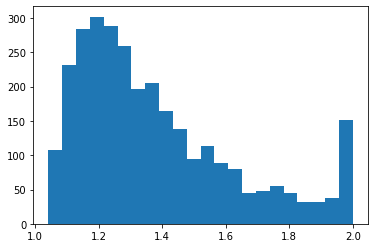

In [140]:
plt.hist(test_eigens, bins='auto')

In [145]:
np.sqrt(MSE)
for i in range(10):
    print(test_eigens[i])
    g = test_graphs[i]
    print(sage_model(g).item())
    print()

tensor(1.9062, dtype=torch.float64)
1.9161728620529175

tensor(1.1942, dtype=torch.float64)
1.1416680812835693

tensor(1.0986, dtype=torch.float64)
1.0649200677871704

tensor(1.1439, dtype=torch.float64)
1.0875033140182495

tensor(1.0846, dtype=torch.float64)
1.0392508506774902

tensor(1.3654, dtype=torch.float64)
1.3460112810134888

tensor(1.3730, dtype=torch.float64)
1.3669610023498535

tensor(1.4909, dtype=torch.float64)
1.533289909362793

tensor(1.7754, dtype=torch.float64)
1.8024663925170898

tensor(1.5213, dtype=torch.float64)
1.521324634552002



In [137]:
class GraphConv_Model(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(GraphConv_Model, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, g):
        h = g.in_degrees().view(-1, 1).float() # # initial node feature will be the the indegree
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        h = F.relu(self.conv3(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [139]:
conv_model = GraphConv_Model(1, 256, 1)
loss_func = nn.MSELoss()
optimizer = optim.Adam(conv_model.parameters(), lr=0.001)
train_dataloader, test_dataloader = get_train_and_test_dataloader("train_graphs", "test_graphs")

print("Data loaded!")
print("Length of training dataset:")
print()
print("Starting Training")

conv_model, losses = train(conv_model, loss_func, optimizer, 1, train_dataloader)

plot_loss_graph(losses)

Data loaded!
Length of training dataset:

Starting Training


ValueError: not enough values to unpack (expected 2, got 1)